In [1]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Configure load path
import pickle
import pandas as pd
import os
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, r2_score, d2_absolute_error_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
import xgboost as xgb
from dateutil.relativedelta import relativedelta
from tqdm import tqdm, tqdm_notebook
import numpy as np
import random
import json
from datetime import datetime, timedelta
import re
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.tree    import DecisionTreeRegressor
from sklearn.tree    import DecisionTreeClassifier
import itertools

os.chdir("C:/Users/Win11/Documents/Repos/Acorn-Casino-PLTV/")

bs_token = 'S7Fek4qridIxY1sUfYUyOl0rLak1Eedeg0TTCWHzUHqIFuUGN07xZtd41ZCp2UvE'  # Token Bingo Arena
host = 'td.winnerstudio.vip'

# Path Thinking Engine tables
tables_path = 'pltv_lucky_accorn_ios_tables.py'
start_date = (datetime.now() - timedelta(days = 65)).strftime('%Y-%m-%d')
end_date = (datetime.now() - timedelta(days = 29)).strftime('%Y-%m-%d')
client_name = 'ios'

# Load queries from remote python script (This needs to be perfect).  Overall, you might want to have the lsit here
exec(open(tables_path).read())
tables = locals().get('tables')

In [3]:
with open('acorn_ios_ptlv_dictionary_2024_jan.pkl', 'rb') as file:
    model_dict = pickle.load(file)
model_dict.head()

,Available day,Target day,Model,Columns
0,7,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
1,8,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
2,9,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
3,10,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
4,11,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."


## 1. Load the data and incorporate the predictions 

This should be everything that you can get from the previous step, except the API data 

In [4]:
def load_data(tables, bs_token, host):
    def pull_data(sql_script, bs_token, host):

        data = {
            'token':          bs_token,
            'format':         'json_object',
            'timeoutSeconds': 2000,
            'sql':            sql_script
        }

        data = str(urlencode(data))
        response = requests.post(f'http://{host}:8992/querySql?{data}', timeout = 1000000)

        # Sample list of JSON strings
        json_list = response.text.split('\n')[1:]

        # Convert JSON strings to dictionaries
        dict_list = []
        for json_str in json_list:
            try:
                dict_list.append(json.loads(json_str))
            except json.JSONDecodeError as e:
                print(f"Error parsing JSON: {e}")

        # Create a pandas DataFrame
        data = pd.DataFrame(dict_list).sort_index(axis = 1)
        print(data)
        # Display the DataFrame
        return data

    # Load the first data using USER_PAYMENT, and then iteatevely join the remaining data for trainning

    df = pull_data(tables[0], bs_token, host)
    for i in range(1, len(tables)):
        new_data = pull_data(tables[i], bs_token, host)
        df = df.merge(new_data, on = '#account_id', how = 'left')

    return df

# Load queries from remote python script (This needs to be perfect).  Overall, you might want to have the lsit here
exec(open(tables_path).read())
tables = locals().get('tables')
training_columns = locals().get('training_columns')
training_columns_feb = locals().get('training_columns_feb')

# Create df by loading information and joining on account_id
df = load_data(tables, bs_token, host)

In [ ]:
# Data preprocessing and transformations
df['#account_id'] = df['#account_id'].astype(str)
df['register_time'] = pd.to_datetime(df['register_time'], errors = 'coerce')
df['date'] = df['register_time'].dt.strftime('%Y%m%d').astype(float)  # Change to float if needed

df = df.fillna(0)

In [ ]:
# Calculate differences
day_columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7']
for i in range(len(day_columns) - 1, 0, -1):
    df[f'{day_columns[i]}_diff'] = df[day_columns[i]] - df[day_columns[i - 1]]

In [ ]:
# Add predictions
integers_list = list(range(7, 28))
incremented_numbers = [str(number) for number in range(28, 36, 7)]
predictors_days_input = predictors_days = [str(integer) for integer in integers_list] + incremented_numbers

# Available dates as target (I am considering adding more values, above and below, maybe up to two on each side)
response_days_input = response_days = ["14", "28", "56", "63", "70", "77", "84", "91", "98", "100", "105", "112", "119", "126", "133"]
def add_predictions(data, model_dict, response_days, predictors_days):

    for response in response_days:
        data[f'actual_{response}'] = data[f'p{response}'] - data[f'w{response}'] + data[f'ad{response}']

        for reg in predictors_days:

            if int(response) > int(reg):
                
                data[f'p_last_diff_7_{reg}'] = data[f'p{reg}'] - data[f'p7']
                data[f'w_last_diff_7_{reg}'] = data[f'w{reg}'] - data[f'w7']
                columns = list((model_dict[(model_dict['Available day'] == reg) & (model_dict['Target day'] == response)][['Columns']].reset_index(drop=True).values[0])[0]) #+ [f'p_last_diff_7_{reg}'] + [f'w_last_diff_7_{reg}']
                
                # Load the model
                model = model_dict[(model_dict['Available day'] == reg) & (model_dict['Target day'] == response)]['Model'].reset_index(drop=True).values[0]

                # Make the prediction (Make sure is done only for those on which makese sense)
                prediction = model.predict(data[columns])
                data[f'pred_{reg}_{response}'] = prediction + data[f'p{reg}']- data[f'w{reg}'] + data[f'ad{reg}']
                del data[f'p_last_diff_7_{reg}']
                del data[f'w_last_diff_7_{reg}']

    return data

df = add_predictions(df, model_dict, response_days_input, predictors_days_input)

## 2. Add media source 

Add the media source

In [ ]:
api_details = {'bundle_id': 'com.acorncasino.slots', 'start': start_date, 'end':  end_date}
api_url = 'http://acorncasino-ios.twilightgift.club/server/media_source_cost'

# Send a GET request to the API
response = requests.post(api_url, api_details)
if response.status_code == 200:
    # Request was successful
    api_df = response.json()  # Parse the JSON response if the API returns JSON data
    api_df = pd.DataFrame(api_df['data'])
    api_df['api_installs'] = api_df['user_ids'].apply(lambda x: len([int(item.strip()) for item in x.split(",") if item.strip()]))
    print('Loaded', api_df.shape)
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")


Loaded (186, 7)


In [ ]:
api_df = api_df.groupby('date')[['cost', 'revenue_d7', 'withdraw_d7', 'api_installs']].sum().reset_index(drop = False).sort_values(by = 'date')
api_df.head()

,date,cost,revenue_d7,withdraw_d7,api_installs
0,20231122,9057.12,8672.69,5648.90,1056
1,20231123,10238.10,6325.87,4663.57,1106
2,20231124,11521.74,14968.13,10929.83,1245
3,20231125,11905.94,8963.85,3919.00,1298
4,20231126,10862.30,10654.07,9428.93,1368


In [ ]:
n_values = df.columns[df.columns.str.match(r'pred_\d+_\d+')].str.extract(r'pred_\d+_(\d+)').dropna()[0].unique() # These are the responses, after removing the availables.
available_k_values = [int(col.split('_')[1]) for col in df.columns if col.startswith('pred_')] # What are the numbers after 'pred_'
pred_list = ['pred_14', 'pred_28', 'pred_56', 'pred_63', 'pred_70', 'pred_77', 'pred_84', 'pred_91', 'pred_98', 'pred_100', 'pred_105', 'pred_112', 'pred_119', 'pred_126', 'pred_133']

df['te_installs'] = 1
agg_df = df.fillna(0).groupby('date')[[col for col in df.columns if col.startswith("p") or col.startswith("w") or col.startswith("ad") or col.startswith("act") or col.startswith("actual_")] + ['te_installs']].sum().reset_index()
agg_df = api_df[['date', 'api_installs', 'cost', 'revenue_d7', 'withdraw_d7']].merge(agg_df, on = 'date', how = 'inner')

agg_df['payment_increase']    = (agg_df['revenue_d7'] - agg_df['p7']) / agg_df['p7']
agg_df['rpi_increase']        = ((agg_df['revenue_d7'] / agg_df['api_installs'].astype(float)) - (agg_df['p7'] / agg_df['te_installs']) / (agg_df['p7'] / agg_df['te_installs']))
agg_df['installs_difference'] = (agg_df['api_installs'] - agg_df['te_installs']) / agg_df['te_installs'] # ['Install', 'installs']'Install' is API
agg_df['withdrawn_ratio']     = agg_df['withdraw_d7'] / agg_df['revenue_d7']
agg_df['return_p_d7']         = agg_df['p7'] / agg_df['cost'] 
agg_df['return_ad_d7']        = agg_df['ad7'] / agg_df['cost'] 
today = pd.to_datetime((datetime.now() - timedelta(days = 1)).strftime('%Y-%m-%d'))


In [ ]:
# Generate pred roas cols by dividing pred_revenue by spending (Name does not change)
agg_df[[col for col in df.columns if col.startswith("pred_")]] = agg_df[[col for col in df.columns if col.startswith("pred_")]].div(agg_df['cost'], axis = 0)

In [ ]:
agg_df_train = agg_df[['date'] + ['cost'] + ['revenue_d7'] + ['withdraw_d7'] + ['payment_increase'] + ['rpi_increase'] + ['installs_difference'] + ['withdrawn_ratio'] 
                        + [col for col in agg_df.columns if col.startswith("pred_")] + [col for col in agg_df.columns if col.startswith("w")]]

agg_df_train.sample(10)

,date,cost,revenue_d7,withdraw_d7,payment_increase,rpi_increase,installs_difference,withdrawn_ratio,pred_7_14,pred_8_14,...,w63,w7,w70,w77,w8,w84,w9,w91,w98,withdrawn_ratio
15,20231207,31059.94,22230.96,13913.74,-0.182290,7.086926,-0.205032,0.625872,0.578227,0.549977,...,123426.6900,14005.06,123426.6900,123426.6900,16763.81,123426.6900,18566.24,123426.6900,123426.6900,0.625872
16,20231208,32423.70,29613.51,18649.65,-0.149415,9.138141,-0.221689,0.629768,0.785177,0.850874,...,137252.2100,14302.74,137252.2100,137252.2100,16133.18,137252.2100,16835.33,137252.2100,137252.2100,0.629768
2,20231124,11521.74,14968.13,10929.83,-0.087016,11.022594,-0.181460,0.730207,0.302229,0.613459,...,45552.9200,14485.12,45552.9200,45552.9200,14930.12,45552.9200,16956.12,45552.9200,45552.9200,0.730207
33,20231225,63913.80,39535.69,18089.01,-0.229558,8.953598,-0.173017,0.457536,0.513744,0.507690,...,92813.5601,27400.39,92813.5601,92813.5601,29290.06,92813.5601,30601.51,92813.5601,92813.5601,0.457536
10,20231202,18622.51,13558.41,9321.44,-0.151724,6.344751,-0.208065,0.687502,0.393813,0.428191,...,40006.6800,10825.81,40006.6800,40006.6800,11445.06,40006.6800,11846.22,40006.6800,40006.6800,0.687502
13,20231205,20987.00,14117.10,6905.50,-0.054096,5.487638,-0.220351,0.489159,0.363694,0.337419,...,54893.6400,8792.53,54893.6400,54893.6400,10093.41,54893.6400,11310.41,54893.6400,54893.6400,0.489159
8,20231130,14595.90,13981.43,11817.97,-0.101181,6.948511,-0.208371,0.845262,0.608924,0.732655,...,29261.8200,9089.10,29261.8200,29261.8200,9612.23,29261.8200,10466.71,29261.8200,29261.8200,0.845262
26,20231218,63990.72,57820.17,30916.24,-0.054747,10.136396,-0.177570,0.534696,0.564089,0.586136,...,167465.3400,34816.10,167465.3400,167465.3400,36078.17,167465.3400,40288.73,167465.3400,167465.3400,0.534696
11,20231203,18166.54,11883.85,7529.60,-0.108259,4.883094,-0.212783,0.633599,0.321257,0.380709,...,44163.0800,9109.51,44163.0800,44163.0800,9871.12,44163.0800,10934.77,44163.0800,44163.0800,0.633599
6,20231128,12087.80,17641.92,8684.99,-0.054328,10.792727,-0.215933,0.492293,0.612402,0.642360,...,47430.1400,13504.75,47430.1400,47430.1400,14051.58,47430.1400,15083.06,47430.1400,47430.1400,0.492293


## Check numbers are pulled decently well


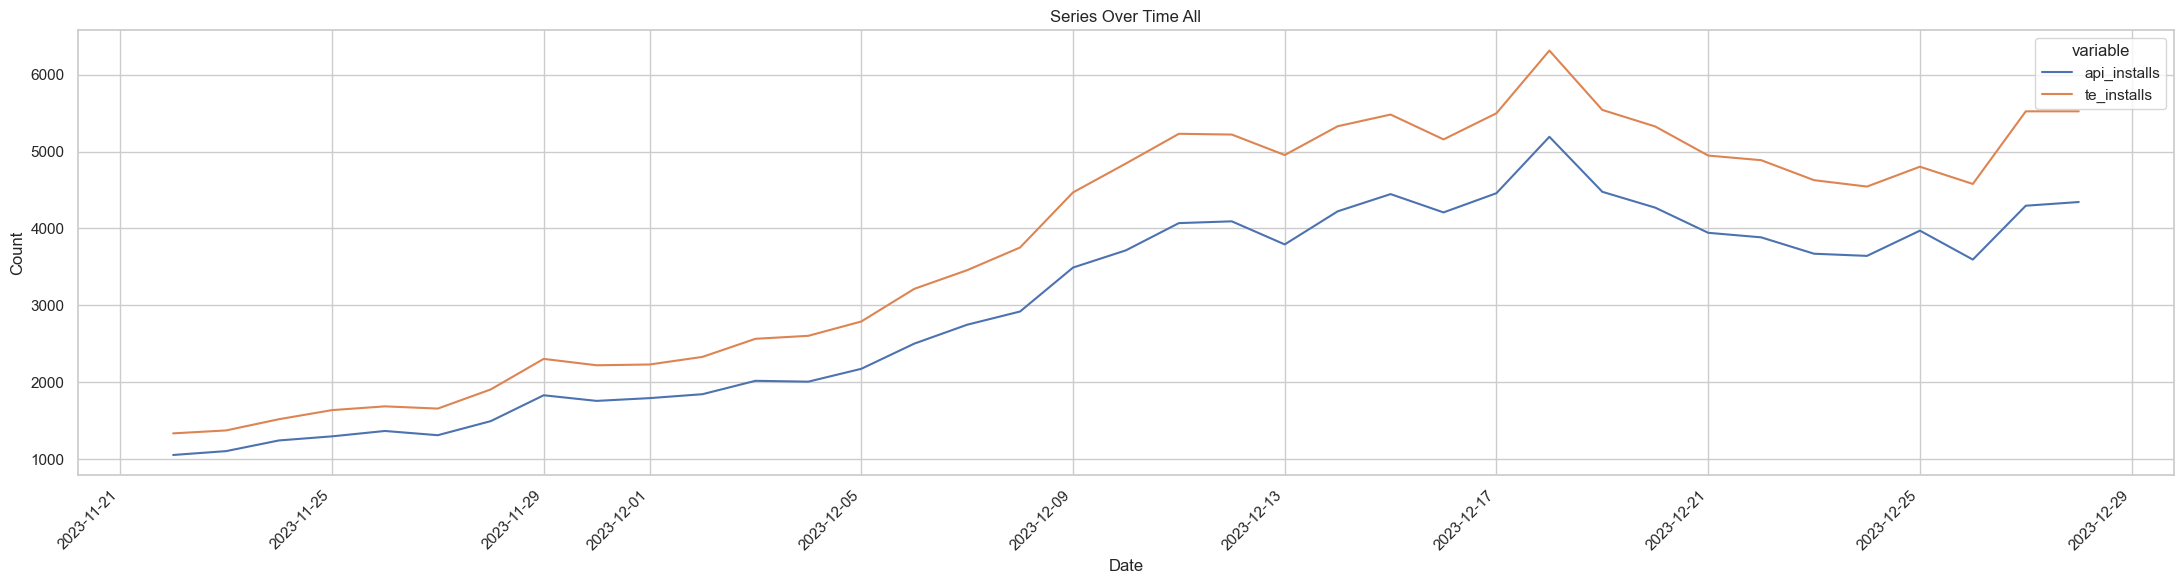

In [ ]:

# Set the seaborn style
sns.set(style="whitegrid")

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(agg_df, id_vars=['date'], value_vars=['api_installs', 'te_installs'])
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Series Over Time All')

# Display the legend
# plt.legend(title='Media Source')

# Set x-axis ticks at specific intervals
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment as needed

# Show the plot
plt.tight_layout()  # Optional for better layout
plt.show()

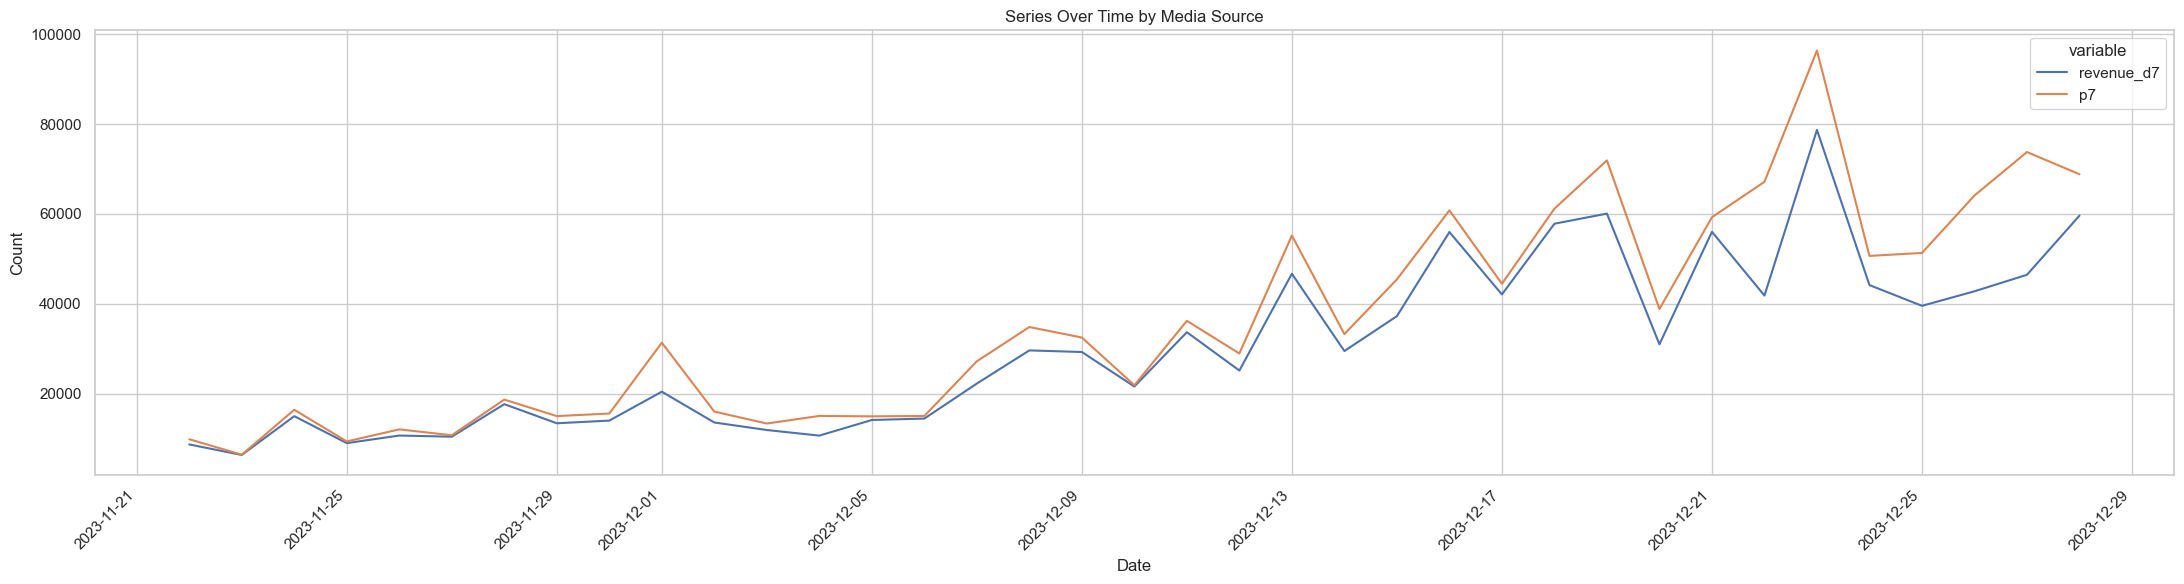

In [ ]:
# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(agg_df, id_vars=['date'], value_vars=['revenue_d7', 'p7'])
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Series Over Time by Media Source')

# Display the legend
# plt.legend(title='Media Source')

# Set x-axis ticks at specific intervals
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment as needed

# Show the plot
plt.tight_layout()  # Optional for better layout
plt.show()

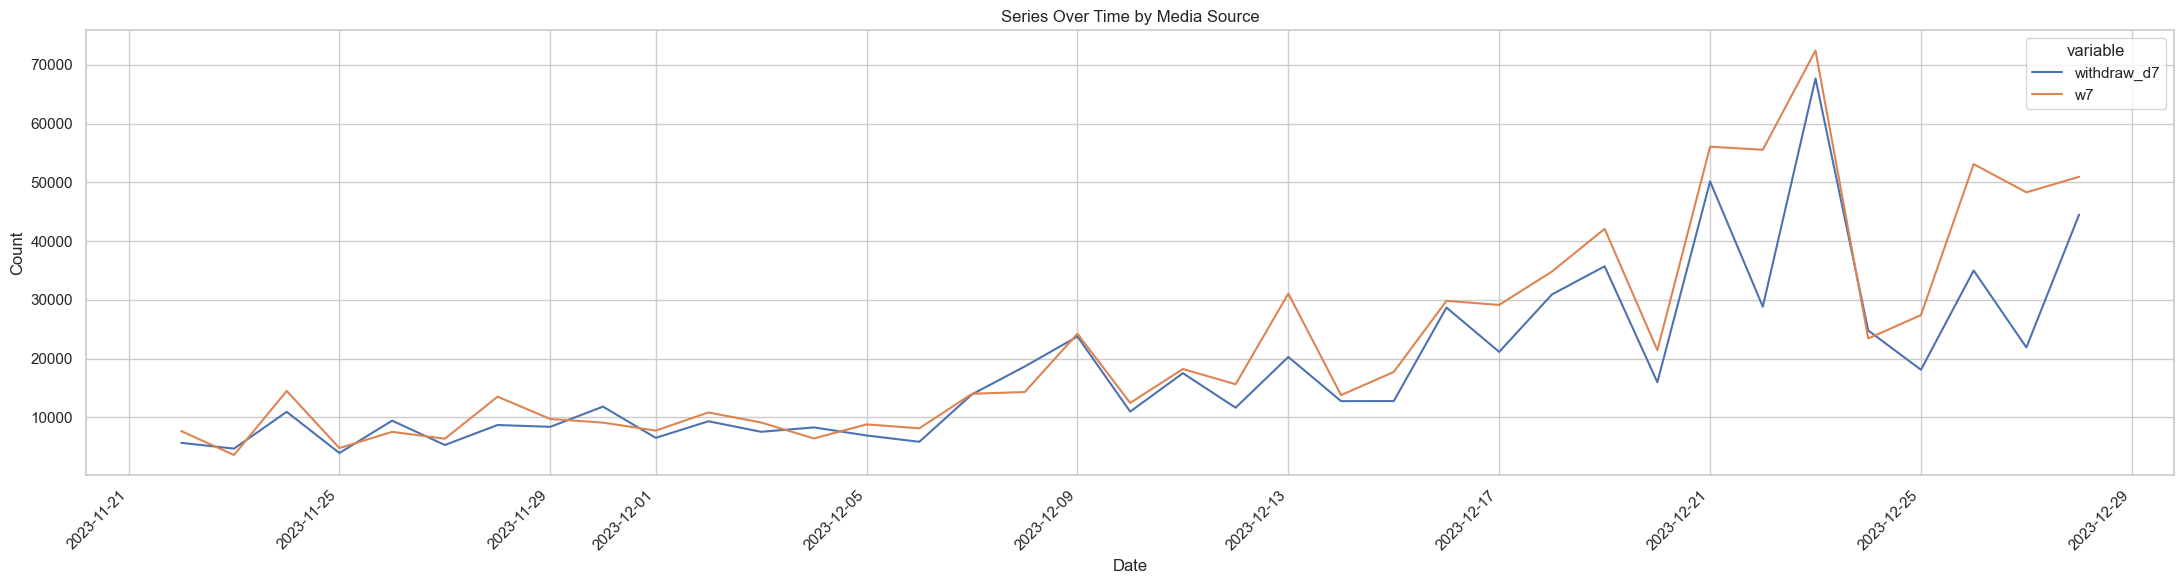

In [ ]:
sns.set(style="whitegrid")

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(agg_df, id_vars=['date'], value_vars=['withdraw_d7', 'w7'])
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Series Over Time by Media Source')

# Display the legend
# plt.legend(title='Media Source')

# Set x-axis ticks at specific intervals
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment as needed

# Show the plot
plt.tight_layout()  # Optional for better layout
plt.show()

## 3. Incorporate the responses from the BI tool 

In [ ]:
file_path = (os.getcwd()).replace('\\', '/') + r'/roi_all_by_user_20240126191117.xlsx'.replace('\\', '/')
bi_tool_actuals = pd.read_excel(file_path)

bi_tool_actuals = bi_tool_actuals[bi_tool_actuals['date'] != '--']

In [ ]:
bi_tool_actuals[['date', '7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)']].sort_values(by = 'date').head(10)

,date,7-day recovery (rate),14-day recycling (rate),Recovery on the 28th (rate)
201,20230701,"5,434.91（26.98%）","6,812.31（33.82%）","8,463.36（42.02%）"
200,20230702,"6,285.81（32.1%）","7,729.50（39.47%）","9,391.31（47.96%）"
199,20230703,"6,571.92（32.45%）","8,410.40（41.53%）","11,210.71（55.36%）"
198,20230704,"6,919.64（35.8%）","8,616.98（44.59%）","11,055.64（57.2%）"
197,20230705,"5,869.21（35.32%）","7,294.75（43.9%）","8,419.84（50.67%）"
196,20230706,"5,429.40（35.01%）","7,254.33（46.77%）","9,238.93（59.57%）"
195,20230707,"5,111.15（36.23%）","6,314.18（44.76%）","7,951.88（56.37%）"
194,20230708,"4,443.10（33.02%）","5,826.80（43.3%）","7,444.19（55.32%）"
193,20230709,"7,599.36（57.2%）","9,683.39（72.89%）","11,869.33（89.35%）"
192,20230710,"5,924.59（43.15%）","7,611.38（55.43%）","9,553.12（69.57%）"


In [ ]:
# Convert percentage strings to floats
def convert_percentage_string_to_float(percentage_string):
    try:
        return float(percentage_string.split(' ')[1][1:-2]) / 100
    except (ValueError, IndexError):
        return float(percentage_string.split('（')[1][0:-2]) / 100

bi_columns = ['7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)','90-day recovery (rate)', '120-day recovery (rate)']
for col in bi_columns:
    bi_tool_actuals[col] = bi_tool_actuals[col].apply(convert_percentage_string_to_float)

bi_tool_actuals[['date', '7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)']].sort_values(by = 'date').head(10)

,date,7-day recovery (rate),14-day recycling (rate),Recovery on the 28th (rate)
201,20230701,0.2698,0.3382,0.4202
200,20230702,0.3210,0.3947,0.4796
199,20230703,0.3245,0.4153,0.5536
198,20230704,0.3580,0.4459,0.5720
197,20230705,0.3532,0.4390,0.5067
196,20230706,0.3501,0.4677,0.5957
195,20230707,0.3623,0.4476,0.5637
194,20230708,0.3302,0.4330,0.5532
193,20230709,0.5720,0.7289,0.8935
192,20230710,0.4315,0.5543,0.6957


In [ ]:
bi_tool_actuals['date'].max()
# bi_tool_actuals['date'].dtype

20240118

In [ ]:
# MERGE BI TOOL TO MY DATA (AGG DF INCLUDES BI DATA)

bi_tool_wanted_cols = ['date', 'Recovery on the 28th (rate)']

# agg_df['channel'] = agg_df['media_source']
# bi_tool_actuals['date'] = pd.to_datetime(bi_tool_actuals['date']).dt.date.apply(lambda x: int(x.strftime('%Y%m%d')))
agg_df = pd.merge(agg_df, bi_tool_actuals[bi_tool_wanted_cols], on = 'date')
agg_df.sample(10)


,date,api_installs,cost,revenue_d7,withdraw_d7,p1,p10,p100,p105,p11,...,pred_35_133,te_installs,payment_increase,rpi_increase,installs_difference,withdrawn_ratio,return_p_d7,return_ad_d7,Recovery on the 28th (rate)_x,Recovery on the 28th (rate)_y
3,20231125,1298,11905.94,8963.85,3919.00,4522.55930,10616.36592,54352.08575,54352.08575,11125.72592,...,2.835279,1639,-0.040412,5.905894,-0.208054,0.437201,0.784596,0.0,0.5569,0.5569
8,20231130,1759,14595.90,13981.43,11817.97,5656.99773,20398.97851,82720.11033,82720.11033,21299.89914,...,3.607897,2222,-0.101181,6.948511,-0.208371,0.845262,1.065733,0.0,0.7316,0.7316
27,20231219,4477,53784.51,60072.01,35709.23,23245.32055,99849.93292,231992.43366,231992.43366,109667.43355,...,3.442633,5541,-0.164743,12.417916,-0.192023,0.594440,1.337195,0.0,0.6560,0.6560
20,20231212,4093,43707.59,25125.52,11637.15,10294.14720,38247.63186,163929.30853,163929.30853,41559.16470,...,2.951800,5221,-0.131335,5.138656,-0.216051,0.463161,0.661768,0.0,0.5647,0.5647
26,20231218,5192,63990.72,57820.17,30916.24,21717.25698,76795.65041,285572.12783,285572.12783,83041.77462,...,3.929244,6313,-0.054747,10.136396,-0.177570,0.534696,0.955904,0.0,0.6102,0.6102
11,20231203,2020,18166.54,11883.85,7529.60,5011.61584,17673.11789,62217.86225,62217.86225,19335.06889,...,2.159670,2566,-0.108259,4.883094,-0.212783,0.633599,0.733578,0.0,0.8929,0.8929
12,20231204,2009,17130.31,10637.27,8277.54,5691.47489,19885.73963,101055.82771,101055.82771,21640.13242,...,3.496607,2605,-0.291781,4.294808,-0.228791,0.778164,0.876794,0.0,0.5714,0.5714
22,20231214,4223,53020.23,29471.48,12752.80,14964.95020,43176.55818,108057.91574,108057.91574,46641.10181,...,1.813690,5329,-0.113603,5.978802,-0.207544,0.432717,0.627093,0.0,0.8958,0.8958
17,20231209,3492,39196.44,29256.02,23753.68,13693.63257,46216.84472,338326.63855,338326.63855,55050.03935,...,5.575907,4469,-0.099177,7.378013,-0.218617,0.811925,0.828570,0.0,0.5978,0.5978
6,20231128,1496,12087.80,17641.92,8684.99,6898.65841,22934.63403,97373.45224,97373.45224,25289.40503,...,5.159078,1908,-0.054328,10.792727,-0.215933,0.492293,1.543328,0.0,0.4450,0.4450


### Day 7 to 14 and 28

### Day 28 to day 100 growth (Pull the data from the BI tool)

In [ ]:
bi_tool_actuals

for col in []:
    bi_tool_actuals[col] = bi_tool_actuals[col].apply(convert_percentage_string_to_float)

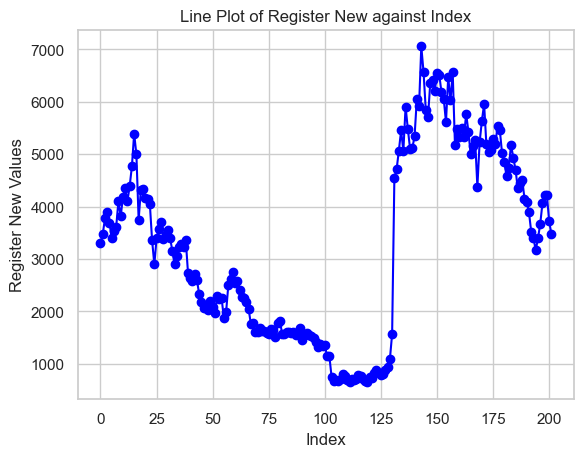

In [ ]:

bi_tool_actuals['Register new'].plot(kind='line', marker='o', linestyle='-', color='blue')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Register New Values')
plt.title('Line Plot of Register New against Index')

# Display the plot
plt.show()

In [ ]:
used_num_bi = bi_tool_actuals[(bi_tool_actuals['date'] > 20231010)].groupby('date')[['Register new'] + columns].sum().reset_index()
used_num_bi['date'] = used_num_bi['date'].astype(str)

used_num_bi['date'] = pd.to_datetime((used_num_bi['date'].astype(str)), format='%Y%m%d').dt.strftime('%Y%m%d')
# used_num_bi['date'].dtype
used_num_bi


,date,Register new,7-day recovery (rate),14-day recycling (rate),Recovery on the 28th (rate),90-day recovery (rate),120-day recovery (rate)
0,20231011,1338,0.7321,0.9146,1.0811,1.3473,1.3944
1,20231012,1372,0.9006,1.1509,1.3569,1.6422,1.6523
2,20231013,1325,0.6486,0.8962,1.0003,1.2059,1.2365
3,20231014,1418,0.6050,0.6401,0.7765,0.9580,0.9690
4,20231015,1488,0.8876,1.2617,1.4177,1.7487,1.7602
...,...,...,...,...,...,...,...
95,20240114,3695,0.3827,0.4290,0.4290,0.4290,0.4290
96,20240115,3887,0.4212,0.5019,0.5019,0.5019,0.5019
97,20240116,3775,0.3834,0.4187,0.4187,0.4187,0.4187
98,20240117,3474,0.3498,0.3807,0.3807,0.3807,0.3807


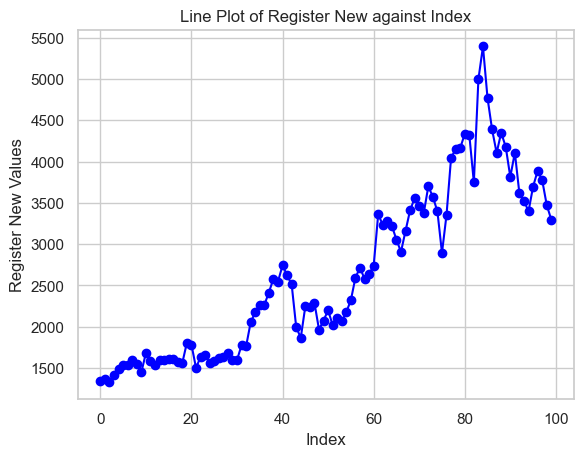

In [ ]:

used_num_bi['Register new'].plot(kind='line', marker='o', linestyle='-', color='blue')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Register New Values')
plt.title('Line Plot of Register New against Index')

# Display the plot
plt.show()

In [ ]:
columns = ['7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)','90-day recovery (rate)', '120-day recovery (rate)']
used_num_bi = bi_tool_actuals[(bi_tool_actuals['date'] > 20231010) & (bi_tool_actuals['date'] <= 20231025)].groupby('date')[columns].sum().reset_index()
used_num_bi['date'] = pd.to_datetime(used_num_bi['date'].astype(str), format='%Y%m%d').dt.strftime('%Y%m%d')


denom = used_num_bi['7-day recovery (rate)'].values
for col in columns:
    print(col)
    used_num_bi[col] = used_num_bi[col] / denom

daily_growth = used_num_bi.mean().reset_index()
daily_growth

7-day recovery (rate)
14-day recycling (rate)
Recovery on the 28th (rate)
90-day recovery (rate)
120-day recovery (rate)


,index,0
0,date,1348734080154008179702400722555897417740479093...
1,7-day recovery (rate),1.0
2,14-day recycling (rate),1.221852
3,Recovery on the 28th (rate),1.47318
4,90-day recovery (rate),1.847519
5,120-day recovery (rate),1.874508


In [ ]:
mult_14 = daily_growth[daily_growth['index'] == '14-day recycling (rate)'][0].values[0]
mult_28 = daily_growth[daily_growth['index'] == 'Recovery on the 28th (rate)'][0].values[0]
linear_growth_rate = (daily_growth[daily_growth['index'] == '90-day recovery (rate)'][0].values[0] - mult_28) / (90 - 35)

print(mult_14, mult_28, linear_growth_rate)

1.2218518277171337 1.473180489144073 0.006806150959772336


### Check the Joint results

In [ ]:
filtered_df = agg_df.copy()#[agg_df['channel'] == sourcesito]
# filtered_df['date'] = pd.to_datetime(filtered_df['date'], format='%Y-%m-%d')
filtered_df = filtered_df.sort_values(by='date')
filtered_df['actual_28'] = filtered_df['actual_28']/filtered_df['cost']

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(filtered_df, id_vars=['date'], value_vars=['Recovery on the 28th (rate)', 'pred_7_28', 'actual_28'])
# df_long['date'] = pd.to_datetime(df_long['date']).dt.date.apply(lambda x: int(x.strftime('%Y%m%d')))
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('ROAS day 28')
plt.title(f'ROAS Over Time Unity: ')

# Display the legend
plt.legend(title='Media Source')

# Rotate X-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

KeyError: "The following 'value_vars' are not present in the DataFrame: ['Recovery on the 28th (rate)']"

## Find the best configuration to train correction rule

In [ ]:
bias = 0.15 



In [ ]:
w_col_names = [col for col in agg_df.columns if re.match(r'^w\d*$', col) is not None]
p_col_names = [col for col in agg_df.columns if re.match(r'^p\d*$', col) is not None]
agg_df_train = agg_df[agg_df['api_installs'] > 50][['date'] + ['te_installs'] + ['cost'] + ['revenue_d7'] + ['withdraw_d7'] + ['payment_increase'] 
                        + ['rpi_increase'] + ['installs_difference'] + ['withdrawn_ratio'] + ['Recovery on the 28th (rate)']
                        + [col for col in agg_df.columns if col.startswith("pred_") ] + w_col_names + p_col_names]

agg_df_train['d7_28_increase_api'] = agg_df_train['Recovery on the 28th (rate)'] - agg_df_train['revenue_d7']/agg_df_train['cost']
agg_df_train['d7_28_increase_pred'] = agg_df_train['pred_7_28'] - (agg_df_train['p7']/agg_df_train['cost'] - agg_df_train['withdraw_d7']/agg_df_train['cost'])
agg_df_train['d7_28_increase_pred'] = agg_df_train['pred_7_28'] - (agg_df_train['p7']/agg_df_train['cost'] - agg_df_train['withdraw_d7']/agg_df_train['cost'])


In [ ]:
# GET THE COLUMN GROUPS
validation_sets = 3
agg_df_train['validation_set_id'] = pd.qcut(agg_df_train['date'].astype(float).values, validation_sets)

In [ ]:
agg_df_train.groupby('validation_set_id').size()

validation_set_id
(20231107.999, 20231124.667]    17
(20231124.667, 20231211.333]    17
(20231211.333, 20231228.0]      17
dtype: int64

In [ ]:
# Check for nulls, infinities and select the model_cols
model_cols = agg_df_train[agg_df_train.columns[5:]].columns
model_cols
null_rows = agg_df_train[agg_df_train['payment_increase'].isnull()]
print(null_rows)
infinity_rows = agg_df_train[np.isinf(agg_df_train['payment_increase'])]
infinity_rows

Empty DataFrame
Columns: [date, te_installs, cost, revenue_d7, withdraw_d7, payment_increase, rpi_increase, installs_difference, withdrawn_ratio, Recovery on the 28th (rate), pred_7_14, pred_8_14, pred_9_14, pred_10_14, pred_11_14, pred_12_14, pred_13_14, pred_7_28, pred_8_28, pred_9_28, pred_10_28, pred_11_28, pred_12_28, pred_13_28, pred_14_28, pred_15_28, pred_16_28, pred_17_28, pred_18_28, pred_19_28, pred_20_28, pred_21_28, pred_22_28, pred_23_28, pred_24_28, pred_25_28, pred_26_28, pred_27_28, pred_7_56, pred_8_56, pred_9_56, pred_10_56, pred_11_56, pred_12_56, pred_13_56, pred_14_56, pred_15_56, pred_16_56, pred_17_56, pred_18_56, pred_19_56, pred_20_56, pred_21_56, pred_22_56, pred_23_56, pred_24_56, pred_25_56, pred_26_56, pred_27_56, pred_28_56, pred_35_56, pred_7_63, pred_8_63, pred_9_63, pred_10_63, pred_11_63, pred_12_63, pred_13_63, pred_14_63, pred_15_63, pred_16_63, pred_17_63, pred_18_63, pred_19_63, pred_20_63, pred_21_63, pred_22_63, pred_23_63, pred_24_63, pred_25_6

,date,te_installs,cost,revenue_d7,withdraw_d7,payment_increase,rpi_increase,installs_difference,withdrawn_ratio,Recovery on the 28th (rate),...,p70,p77,p8,p84,p9,p91,p98,d7_28_increase_api,d7_28_increase_pred,validation_set_id


### Modelling

In [ ]:
# Define predictive model and the polynomial transformation (This should be kept for the dictionary with the exception of the dynamic column. In this case: d7_28_increase_pred)

## Addition
agg_df_train['return_withdraw_d7'] = agg_df_train['withdraw_d7'] / agg_df_train['cost'] 
agg_df_train['return_p_d7'] = agg_df_train['p7'] / agg_df_train['cost'] 

## Definintion in list 
model_cols = ['return_withdraw_d7', 'return_p_d7', 'payment_increase', 'rpi_increase', 'installs_difference', 'withdrawn_ratio', 'd7_28_increase_api', 'd7_28_increase_pred', 'te_installs']

## Algorithm 
def create_huber(alpha, epsi, cols, weights_train): 
    
    columns = cols
    preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), columns)
        ],
        remainder='passthrough'
    )


    # Create the pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', HuberRegressor(fit_intercept = True, epsilon = epsi, alpha = alpha, warm_start = False, max_iter = 1000))
    ])

    pipe.named_steps['regressor'].sample_weight = weights_train

    return pipe

## Feat engineering
def all_feature_enginerring(data, pred_col):

    """
    This is better to create before and the just utilise it in whatever model
        - Notice what you're doing with withdrawal day 100 (I am not so interested in withdrawal but it is fine)
    """
    
    # Inclusion of interpolation 
    column_list = ['withdrawn_ratio', pred_col, 'installs_difference']
    column_combinations = list(itertools.combinations(column_list, 2))

    for pair in column_combinations:
        column1, column2 = pair
        new_column_name = f"{column1}_times_{column2}"
        data[new_column_name] = data[column1] * data[column2]  # Example: Multiply values of two columns

    return data


In [ ]:
model_results = []
all_model_results = []
alphas = [0, 0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2] 
epsils = [1, 1.05, 1.1, 1.3, 1.5, 1.7, 2, 2.5, 3] 

# for train_index, test_index in splits:
for date_group in tqdm(agg_df_train['validation_set_id'].unique()):
    
    print(date_group)

    train_data =  agg_df_train[agg_df_train['validation_set_id'] != date_group][model_cols]
    test_data =  agg_df_train[agg_df_train['validation_set_id'] == date_group][model_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'd7_28_increase_api']), train_data[f'd7_28_increase_api'] 
    X_test, y_test = test_data.drop(columns = [f'd7_28_increase_api']), test_data[f'd7_28_increase_api']

    old_cols = X_train[[col for col in X_train.columns if col != 'te_installs']].copy().columns
    X_train = all_feature_enginerring(X_train, 'd7_28_increase_pred')
    X_test = all_feature_enginerring(X_test, 'd7_28_increase_pred')

    weights_train = np.log1p(X_train['te_installs'])

    for alpha in alphas: 
        for epsi in epsils: 
            for cols in [old_cols, X_train.columns]:
                
                # Full trainning and testing 
                model = create_huber(alpha, epsi, old_cols, weights_train)
                model.fit(X_train[[col for col in cols if col != 'te_installs']], y_train)
                predictions = model.predict(X_test[[col for col in X_train.columns if col != 'te_installs']])
                mae = mean_absolute_error(y_test, predictions)
                r2 = r2_score(y_test, predictions)

                # Save the model into dictionary (Response, day, mo...)
                model_result = pd.DataFrame({
                    'Iteration': [str(alpha) + ' - ' + str(epsi) + ' - ' + str(len([col for col in cols if col != 'te_installs']))]
                    , 'Test at': [date_group]
                    , 'Model': [model]
                    , 'mae': [mae]
                    , 'r2': [r2]
                    , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
                })

                model_results.append(model_result)
    all_model_results.extend(model_results)

all_model_results = pd.concat(all_model_results, ignore_index = True)
all_model_results.shape[0]


  0%|          | 0/3 [00:00<?, ?it/s]

(20231107.999, 20231124.667]


 33%|███▎      | 1/3 [00:02<00:05,  2.73s/it]

(20231124.667, 20231211.333]


 67%|██████▋   | 2/3 [00:07<00:03,  3.73s/it]

(20231211.333, 20231228.0]


100%|██████████| 3/3 [00:09<00:00,  3.17s/it]


864

In [ ]:
all_model_results.sort_values(by = 'mae').head(5)

,Iteration,Test at,Model,mae,r2,rel_mae
424,0.2 - 1.7 - 7,"(20231124.667, 20231211.333]","(ColumnTransformer(remainder='passthrough',\n ...",0.148505,0.525185,0.376754
712,0.2 - 1.7 - 7,"(20231124.667, 20231211.333]","(ColumnTransformer(remainder='passthrough',\n ...",0.148505,0.525185,0.376754
694,0.15 - 1.7 - 7,"(20231124.667, 20231211.333]","(ColumnTransformer(remainder='passthrough',\n ...",0.148772,0.525233,0.375630
406,0.15 - 1.7 - 7,"(20231124.667, 20231211.333]","(ColumnTransformer(remainder='passthrough',\n ...",0.148772,0.525233,0.375630
388,0.1 - 1.7 - 7,"(20231124.667, 20231211.333]","(ColumnTransformer(remainder='passthrough',\n ...",0.149044,0.525272,0.374490


In [ ]:
all_model_results.groupby('Iteration')[['mae', 'r2', 'rel_mae']].mean().sort_values(by = 'mae', ascending = True).head(10)

,mae,r2,rel_mae
Iteration,,,
0.2 - 3 - 7,0.313248,-0.099427,-0.030224
0.15 - 3 - 7,0.313457,-0.097744,-0.030841
0.1 - 3 - 7,0.313672,-0.096013,-0.031481
0.05 - 3 - 7,0.313881,-0.094160,-0.032101
0.02 - 3 - 7,0.314008,-0.093015,-0.032478
0.01 - 3 - 7,0.314049,-0.092615,-0.032600
0.005 - 3 - 7,0.314070,-0.092417,-0.032662
0 - 3 - 7,0.314090,-0.092217,-0.032724
0.2 - 3 - 10,0.328564,-0.245279,-0.095513


In [ ]:
model_value = all_model_results.loc[all_model_results['Iteration'] == '0.2 - 1 - 10', 'Model'].iloc[0]
reset_df_plus = all_feature_enginerring(agg_df_train, 'd7_28_increase_pred')
cols_to_append = [
    'roas_d7_times_installs_difference',
    'withdrawn_ratio_times_installs_difference',
    'withdrawn_ratio_times_pred_7_28',
    'roas_d7_times_pred_7_28',
    'roas_d7_times_withdrawn_ratio',
    'pred_7_28_times_installs_difference'
]
cols_to_append = [
    'withdrawn_ratio_times_d7_28_increase_pred',
    'withdrawn_ratio_times_installs_difference',
    'd7_28_increase_pred_times_installs_difference']

subnormal = [col for col in old_cols if col != 'Installs']
subnormal.extend(cols_to_append)

predictions = model_value.predict(reset_df_plus[subnormal])

In [1]:
import plotly.express as px

# Assuming reset_df is your DataFrame
pdf = pd.DataFrame({'y_test': agg_df_train['d7_28_increase_api'].values, 'ROAS D7': (agg_df_train['revenue_d7']/agg_df_train['cost']), 'installs': agg_df_train['te_installs']})

# Create a scatter plot with size and color based on 'installs' and 'channel'
fig = px.scatter(pdf, x='predictions', y='y_test', title='Association Actuals vs ROAS day 7', trendline='ols',
                 labels={'predictions': 'X-axis Label', 'y_test': 'Y-axis Label'},
                 template='plotly_dark',
                 hover_data=['predictions', 'y_test'],
                 size='installs'
                 )

# Customize the layout
fig.update_layout(
    width=1700,
    height=800,
    xaxis=dict(title_text='Predicted'),
    yaxis=dict(title_text='Actual user revenue'),
    legend=dict(title='Legend Title'),
    showlegend=True
)

# Show the plot
fig.show()

NameError: name 'pd' is not defined

In [ ]:
pdf = pd.DataFrame({'y_test': agg_df_train['d7_28_increase_api'].values, 'predictions': predictions, 'installs': agg_df_train['te_installs']})

fig = px.scatter(pdf, x='predictions', y='y_test', title='Association Actuals vs Predictions', trendline='ols',
                 labels={'predictions': 'X-axis Label', 'y_test': 'Y-axis Label'},
                 template='plotly_dark',
                 hover_data=['predictions', 'y_test'],
                 size='installs',  # Set size proportional to 'installs'
                 )

# Customize the layout
fig.update_layout(
    width=1700,
    height=800,
    xaxis=dict(title_text='Predicted'),
    yaxis=dict(title_text='Actual user revenue'),
    legend=dict(title='Legend Title'),
    showlegend=True
)

# Show the plot
fig.show()

In [ ]:
pdf = pd.DataFrame({'y_test': ((agg_df_train['revenue_d7'].values - agg_df_train['withdraw_d7'].values)/agg_df_train['cost'].values + agg_df_train['d7_28_increase_api'].values), 'predictions': ((agg_df_train['revenue_d7'].values - agg_df_train['withdraw_d7'].values)/agg_df_train['cost'].values + predictions)})

fig = px.scatter(pdf, x='predictions', y='y_test', title='Association Actuals vs Predictions', trendline='ols',
                 labels={'predictions': 'X-axis Label', 'y_test': 'Y-axis Label'},
                 template='plotly_dark',
                 hover_data=['predictions', 'y_test']
                )

# Customize the layout
fig.update_layout(
    width=1700,
    height=800,
    xaxis=dict(title_text='Predicted'),
    yaxis=dict(title_text='Actual user revenue'),
    legend=dict(title='Legend Title'),
    showlegend=True
)

# Show the plot
fig.show()

## Fit to dictionary based on availables

In [102]:
dev_df = agg_df_train.copy(deep = True)

columns_rule = ['revenue_d7','withdraw_d7','installs','payment_increase','rpi_increase','installs_difference','is_facebook','pred_roas','roas_d7','withdrawn_ratio']
columns_rule = ['revenue_d7','withdraw_d7','payment_increase','rpi_increase','installs_difference']

max_date = df['date'].max()
dev_df['days_since_install'] = (max_date - dev_df['date']) # Needed? Yes


In [103]:
payback_predictive_system = []

from tqdm import tqdm, tqdm_notebook

for y_day in tqdm(['14', '28']):
  for x_day in predictors_days:
    if int(y_day) > int(x_day):
  
      train = dev_df.copy()
      train['y'] = train['Recovery on the 28th (rate)'] - (train[f'p{x_day}'] - train[f'w{x_day}'] + train[f'ad{x_day}'])/train['cost']
      y = train[train['days_since_install'] <= (int(y_day) - 1)]['y'] # This is the regressors-based of d7_28_increment
      del train['y']
  
      # Make the regressors
      selected_columns = columns_rule + [f'pred_{x_day}_{y_day}']
      
      # Define X 
      X = train[train['days_since_install'] <= (int(y_day) - 1)]
      weights_train = np.log1p(X['te_installs'])
  
      # Define observation importance 0.01 - 1.05 - 160 - 1 - 10
      model = create_huber(0.0, 1.05, selected_columns, weights_train)
      model.fit(X[[col for col in selected_columns if col != 'te_installs']], y)
  
      # Save the model into dictionary (Response, day, model)
      payback = pd.DataFrame({
              'Available day': [x_day]
              , 'Target day': [y_day]
              , 'Model': [model]
              , 'Columns': [X[[col for col in selected_columns if col != 'te_installs']].columns]
              })
  
      payback_predictive_system.append(payback)

rules_dict = pd.concat(payback_predictive_system, ignore_index = True)
rules_dict

100%|██████████| 2/2 [00:00<00:00,  4.42it/s]


,Available day,Target day,Model,Columns
0,7,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
1,8,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
2,9,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
3,10,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
4,11,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
5,12,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
6,13,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
7,7,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
8,8,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
9,9,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."


In [104]:
dev_df_check = dev_df.copy(deep = True)

In [105]:
# Add predictions
integers_list = list(range(7, 28))
incremented_numbers = [str(number) for number in range(28, 36, 7)]
predictors_days_input = predictors_days = [str(integer) for integer in integers_list] + incremented_numbers

# Available dates as target (I am considering adding more values, above and below, maybe up to two on each side)
response_days_input = response_days = ["14", "28", "56", "63", "70", "77", "84", "91", "98", "100", "105", "112", "119", "126", "133"]

def add_predictions(data, model_dict, response_days, predictors_days):

    for response in response_days:

        data[f'actual_{response}'] = data[f'p{response}'] - data[f'w{response}'] + data[f'ad{response}'] 

        for reg in predictors_days:

            if int(response) > int(reg):
                                
                columns = list((model_dict[(model_dict['Available day'] == reg) & (model_dict['Target day'] == response)][['Columns']].reset_index(drop = True).values[0])[0]) #+ [f'p_last_diff_7_{reg}'] + [f'w_last_diff_7_{reg}']
    
                # Load the model
                model = model_dict[(model_dict['Available day'] == reg) & (model_dict['Target day'] == response)]['Model'].reset_index(drop = True).values[0]
    
                # Make the prediction (Make sure is done only for those on which makese sense)
                prediction = model.predict(data[columns])
                data[f'pred_{reg}_{response}_agg'] = prediction + (data[f'p{reg}']- data[f'w{reg}'] + data[f'ad{reg}'])/data[f'cost']
                
    return data

dev_df_check = add_predictions(dev_df_check, rules_dict, ['28'], predictors_days_input)


In [106]:
dev_df_check.sample(6)

,date,te_installs,cost,revenue_d7,withdraw_d7,payment_increase,rpi_increase,installs_difference,withdrawn_ratio,Recovery on the 28th (rate),...,pred_18_28_agg,pred_19_28_agg,pred_20_28_agg,pred_21_28_agg,pred_22_28_agg,pred_23_28_agg,pred_24_28_agg,pred_25_28_agg,pred_26_28_agg,pred_27_28_agg
4,20231112,2730,6357.49,5789.05,3883.02,-0.677854,6.000060,-0.697070,0.670753,0.8656,...,2.421619,2.754117,2.351796,2.104446,2.112749,1.822192,2.383822,2.898402,2.763233,2.252031
45,20231223,4642,59061.96,78702.36,67696.19,-0.183431,20.433105,-0.208962,0.860155,0.3054,...,0.305400,0.305400,0.305400,0.305400,0.305400,0.305400,0.305400,0.305400,0.305400,0.305400
44,20231222,4910,57584.45,41825.53,28837.73,-0.377087,9.765902,-0.208758,0.689477,0.2780,...,0.188211,0.192005,0.247772,0.182971,0.243844,0.207034,0.207336,0.179423,0.173619,0.197554
48,20231226,4592,63086.76,42776.45,35004.30,-0.332715,10.895565,-0.216899,0.818308,0.3337,...,0.333700,0.333700,0.333700,0.333700,0.333700,0.348857,0.366065,0.366575,0.333700,0.333700
15,20231123,1415,10238.10,6325.87,4663.57,-0.009124,4.719593,-0.218375,0.737222,0.2479,...,0.554079,0.548327,0.557832,0.566301,0.569154,0.583474,0.581430,0.570868,0.567349,0.593423
38,20231216,5193,53679.00,55968.22,28679.86,-0.080520,12.297273,-0.189486,0.512431,0.3596,...,0.359600,0.349346,0.334284,0.310860,0.346893,0.359600,0.359600,0.359600,0.327942,0.344175


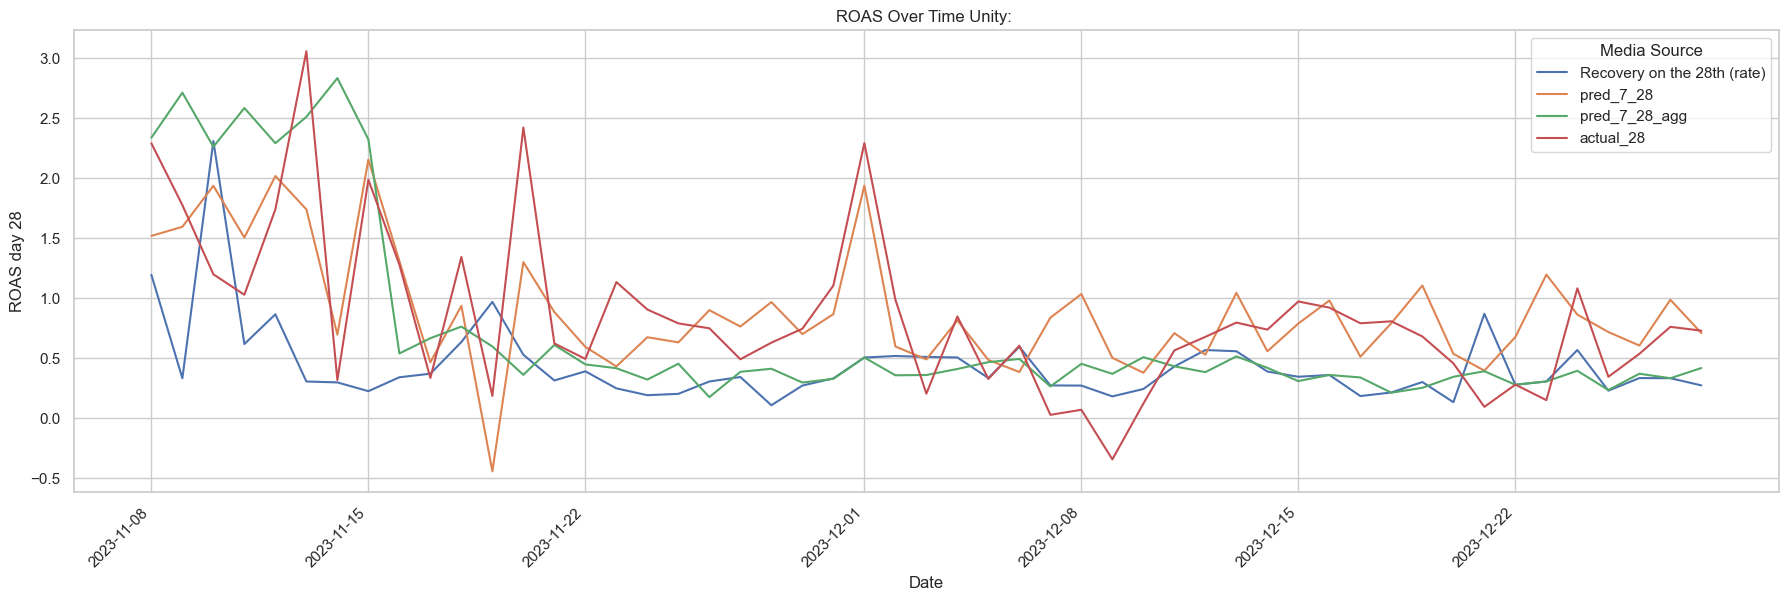

In [107]:
### Check the Joint results

filtered_df = dev_df_check.copy()
# filtered_df['date'] = pd.to_datetime(filtered_df['date'], format='%Y-%m-%d')
filtered_df = filtered_df.sort_values(by = 'date')
filtered_df['actual_28'] = filtered_df['actual_28']/filtered_df['cost']

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(filtered_df, id_vars=['date'], value_vars=['Recovery on the 28th (rate)', 'pred_7_28', 'pred_7_28_agg', 'actual_28'])
# df_long['date'] = pd.to_datetime(df_long['date']).dt.date.apply(lambda x: int(x.strftime('%Y%m%d')))
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('ROAS day 28')
plt.title(f'ROAS Over Time Unity: ')

# Display the legend
plt.legend(title='Media Source')

# Rotate X-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [108]:
# Remove the last data points and remove the pred_ columns. This is too much
with open('acorn_games_ios_ptlv_dictionary_2024.pkl', 'wb') as file:
    pickle.dump(rules_dict, file)